In [11]:
%%capture
import mne
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy.signal import welch
from pyts.image import GramianAngularField

In [12]:
%%capture
#Convert to DataFrame
def convert_bdf_to_dataframe(bdf_filename):
    raw_data = mne.io.read_raw_bdf(bdf_filename, preload=True)
    raw_data._data = raw_data._data ** 2
    
    eeg_data_raw = raw_data.get_data()
    channel_names = raw_data.ch_names
    time_index = raw_data.times
    eeg_data = pd.DataFrame(data=eeg_data_raw.T, columns=channel_names, index=time_index)
    col_names = ['O1', 'O2', 'F3', 'F4', 'C3' ,'C4' , 'Fp1', 'Fp2']
    eeg_data = eeg_data[col_names]
    #segment_size = 1024
    #num_segments = len(eeg_data) // segment_size
    #reduced_df = pd.DataFrame(columns=eeg_data.columns)
    #for i in range(num_segments):
    #    start_idx = i * segment_size
    #    end_idx = (i + 1) * segment_size
    #    segment_data = eeg_data.iloc[start_idx:end_idx]    
    #    mean_values = segment_data.mean()
    #    reduced_df = reduced_df.append(mean_values, ignore_index=True)

    return eeg_data

In [13]:
%%capture
# Define a function to extract labels from filenames
def extract_label_from_filename(filename):
    # Assuming filenames are in the format: subject_task.bdf
    task = filename.split('_')[1].split('.')[0]
    sub = filename.split('_')[0]
    return task, sub

In [14]:
%%capture


# Example code to create a spectrogram image from each EEG channel
def eeg_channel_to_spectrogram(eeg_data, channel_name, ch_idx):
    #plt.specgram(channel_data, NFFT=256, Fs=1000, noverlap=128)
    #plt.axis('off')  # Turn off axis
    #plt.savefig(f'{ch_idx}_channel_spectrogram.png', bbox_inches='tight', pad_inches=0)
    method = 'difference'
    gaf = GramianAngularField(image_size=32, method=method)
    channel_data = eeg_data[channel_name].values
    channel_data_1d = channel_data.reshape(-1, 32)
    channel_gaf = gaf.fit_transform(channel_data_1d)
    #plt.imshow(channel_gaf[0], cmap='viridis')
    plt.imsave(f'{channel_name}_channel_spectrogram.png', channel_gaf[0], cmap='viridis')
    plt.close()
    image = Image.open(f'{channel_name}_channel_spectrogram.png')
    path = f'{channel_name}_channel_spectrogram.png'
    return image, path

In [15]:
%%capture

from PIL import Image
data_dir = '../Rishikest_MIT_Dataset/'  # Replace with the path to your .bdf data directory (./Dataset-2/)
eeg_channel_images = []
subject_data = {}

In [16]:
%%capture
# Load and preprocess the data

output_dir_med = './output_images/Meditation'
output_dir_think = './output_images/Thinking'
os.makedirs(output_dir_med, exist_ok=True)
os.makedirs(output_dir_think, exist_ok=True)
i = 197

# Loop through all files in the directory
for filename in os.listdir(data_dir):
    if filename.endswith('.bdf'):
        # Convert the .bdf file to a DataFrame
        eeg_data = convert_bdf_to_dataframe(os.path.join(data_dir, filename))
        
        # Extract labels from filenames
        label, sub = extract_label_from_filename(filename)
        Dirs = ''
        subject = f'sub{i}'
        if 'med'in label:
#             Dirs = f'./output_images/{subject}_Med'
            Dirs = f'{output_dir_med}/{subject}'
            os.makedirs(Dirs, exist_ok=True)
        else:
#             Dirs = f'./output_images/{subject}_Think'
            Dirs = f'{output_dir_think}/{subject}'
            os.makedirs(Dirs, exist_ok=True)
        
        
        for channel_idx in range(eeg_data.shape[1]):
            channel_name = eeg_data.columns[channel_idx]
            #channel_data = eeg_data.iloc[:,channel_idx]
            #channel_data = eeg_data[channel_name]
            #channel_image, path = eeg_channel_to_spectrogram(channel_data, eeg_data.columns[channel_idx])
            channel_image, path = eeg_channel_to_spectrogram(eeg_data, channel_name, channel_idx)
            image_path = os.path.join(Dirs, path)
            print(image_path)
            channel_image.save(image_path)
#             eeg_channel_images.append(image_filename)
            if subject not in subject_data:
                subject_data[subject] = []
            #subject_data[subject].append(channel_data)
            subject_data[subject].append(eeg_data[channel_name])
        i+=1 

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [2]:
data_directory = "./train_test_split/"
image_size = (256, 256)  # Adjust to your desired image size
batch_size = 16  # Adjust as needed
# validation_split = 0.1  # 20% of the data for validation
# test_split = 0.1  # 10% of the data for testing


In [3]:
# subfolder_names = os.listdir(data_directory)

# num_classes = 2  # Specify the number of classes (in this case, 2)

# # Split data into train, validation, and test sets
# # subfolder_names = os.listdir(data_directory)
# # train_data, test_data = train_test_split(
# #     subfolder_names,
# #     test_size=test_split,
# #     random_state=42,
# #     stratify=None  # No need to stratify with only two classes
# # )

# # train_data, val_data = train_test_split(
# #     train_data,
# #     test_size=validation_split,
# #     random_state=42,
# #     stratify=None  # No need to stratify with only two classes
# # )

# # Create data generators
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# train_generator = train_datagen.flow_from_directory(
#     data_directory,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='binary',  # Use 'binary' for binary classification
#     subset='training',
#     shuffle=True  # Shuffle training data
# )

# validation_generator = train_datagen.flow_from_directory(
#     data_directory,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='binary',  # Use 'binary' for binary classification
#     subset='validation',
#     shuffle=False  # Do not shuffle validation data
# )

# test_datagen = ImageDataGenerator(rescale=1./255)

# test_generator = test_datagen.flow_from_directory(
#     data_directory,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='binary',  # Use 'binary' for binary classification
#     subset=None,  # Test set should not be a subset of train/val
#     shuffle=False  # Do not shuffle test data
# )

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_dir = './train_test_split/train/'
test_dir = './train_test_split/test/'
val_dir = './train_test_split/valid/'


image_size = (224, 224)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 224 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 96 images belonging to 2 classes.


In [5]:
NUM_CLASSES = 2

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 256
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'binary_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 5

STEPS_PER_EPOCH_TRAINING = 8
STEPS_PER_EPOCH_VALIDATION = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from keras.layers import Dropout


#resnet_weights_path =  r"D:\ML\ML-codes\resnet50_weights_.h5"
Model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
Model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet',input_shape=(256,256,3)))
Model.add(Dropout(0.1))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
Model.add(Dense(2, activation = DENSE_LAYER_ACTIVATION))
for layer in Model.layers[:-3]:  # Unfreeze the last few layers
    layer.trainable = True

# Say not to train first layer (ResNet) model as it is already trained
Model.layers[0].trainable = False

In [7]:
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
for i, layer in enumerate(Model.layers):
    # Check if the layer is trainable
    if layer.trainable:
        print(f"Layer {i} ({layer.name}) is trainable")
    else:
        print(f"Layer {i} ({layer.name}) is not trainable")

Layer 0 (resnet50) is not trainable
Layer 1 (dropout) is trainable
Layer 2 (dense) is trainable


In [9]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate = 0.0000000001,  momentum = 0.9, nesterov = True)
Model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)


from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# train_generator = data_generator.flow_from_directory(
#         r"/workspace/train",
#         target_size=(image_size, image_size),
#         batch_size=BATCH_SIZE_TRAINING,
#         class_mode='categorical')

# validation_generator = data_generator.flow_from_directory(
#         r"/workspace/test",
#         target_size=(image_size, image_size),
#         batch_size=BATCH_SIZE_VALIDATION,
#         class_mode='categorical') 

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'accuracy', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = r'./resnet50.hdf5', monitor = 'accuracy', save_best_only = True, mode = 'auto')


fit_history = Model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=val_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)

Epoch 1/10
8/8 [==============================] - 13s 1s/step - loss: 0.9537 - accuracy: 0.5000 - val_loss: 0.9181 - val_accuracy: 0.5208
Epoch 2/10
8/8 [==============================] - 7s 928ms/step - loss: 0.9816 - accuracy: 0.4766 - val_loss: 1.0414 - val_accuracy: 0.4375
Epoch 3/10
8/8 [==============================] - 8s 996ms/step - loss: 0.8991 - accuracy: 0.5391 - val_loss: 1.0072 - val_accuracy: 0.4583
Epoch 4/10
8/8 [==============================] - 7s 932ms/step - loss: 1.0030 - accuracy: 0.4688 - val_loss: 1.1024 - val_accuracy: 0.3958
Epoch 5/10
8/8 [==============================] - 8s 945ms/step - loss: 0.9910 - accuracy: 0.4844 - val_loss: 0.9180 - val_accuracy: 0.5208
Epoch 6/10
8/8 [==============================] - 8s 958ms/step - loss: 0.9624 - accuracy: 0.4922 - val_loss: 1.0143 - val_accuracy: 0.4583
Epoch 7/10
8/8 [==============================] - 8s 969ms/step - loss: 1.0020 - accuracy: 0.4688 - val_loss: 0.8878 - val_accuracy: 0.5417
Epoch 8/10
8/8 [======

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


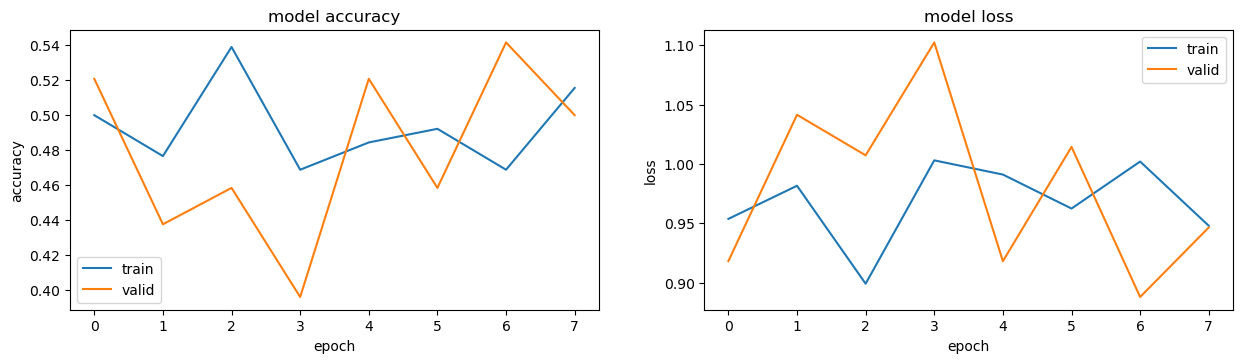

In [12]:
import matplotlib.pyplot as plt
print(fit_history.history.keys())

plt.figure(1, figsize = (15,8)) 

plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.figure(1, figsize = (15,8)) 
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [34]:
# test_generator = data_generator.flow_from_directory(
#     directory = r"/workspace/test",
#     target_size = (image_size, image_size),
#     batch_size = BATCH_SIZE_TESTING,
#     class_mode = None,
#     shuffle = False,
#     seed = 123
# )
import numpy as np

# test_generator.reset()

pred = Model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)


C:\Users\Siddarth\AppData\Local\Temp\ipykernel_15772\3820456420.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = Model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)


3/3 [==============================] - 3s 734ms/step


In [35]:
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

res_preds = Model.predict(test_generator)
res_pred_classes = np.argmax(res_preds, axis=1)

3/3 [==============================] - 2s 646ms/step


In [36]:
from sklearn.metrics import accuracy_score

res_acc = accuracy_score(true_classes, res_pred_classes)
print("ResNet50 Model Accuracy with Fine-Tuning: {:.2f}%".format(res_acc * 100))

ResNet50 Model Accuracy with Fine-Tuning: 50.00%


6/6 [==============================] - 4s 587ms/step


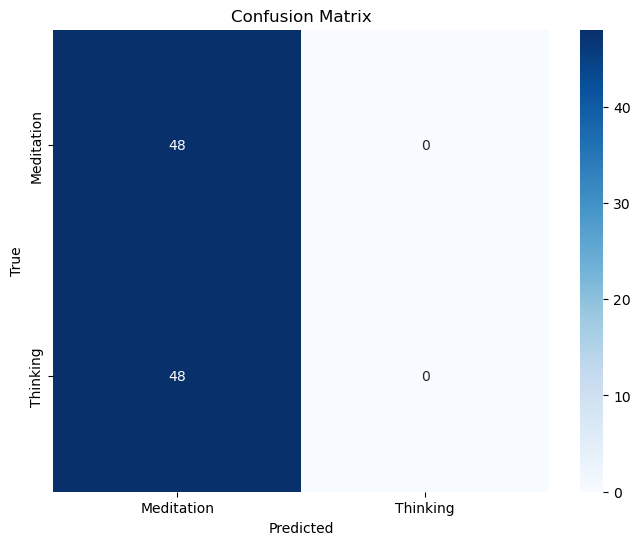

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Load the best saved model (if using ModelCheckpoint)
# model.load_weights('vgg19.hdf5')

# Assuming you have test data and labels in test_generator
# Make predictions using your trained model
predictions = Model.predict(val_generator)

# Convert the predictions to binary labels (0 or 1)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = val_generator.classes
# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Load the best saved model (if using ModelCheckpoint)
# model.load_weights('vgg19.hdf5')

# Assuming you have test data and labels in test_generator
# Make predictions using your trained model
predictions = Model.predict(val_generator)

6/6 [==============================] - 4s 609ms/step


In [18]:
predictions

array([[0.9505783 , 0.0494217 ],
       [0.9508951 , 0.04910491],
       [0.94735086, 0.05264918],
       [0.95164806, 0.04835184],
       [0.9507598 , 0.04924003],
       [0.94969064, 0.0503093 ],
       [0.9530798 , 0.04692022],
       [0.95073295, 0.04926698],
       [0.94996405, 0.05003598],
       [0.94903326, 0.05096671],
       [0.9497648 , 0.05023526],
       [0.9482331 , 0.05176689],
       [0.94762385, 0.05237611],
       [0.950119  , 0.04988088],
       [0.9496603 , 0.05033968],
       [0.9477079 , 0.05229212],
       [0.95474166, 0.04525831],
       [0.94726735, 0.05273253],
       [0.9518629 , 0.0481371 ],
       [0.94574517, 0.05425474],
       [0.9536015 , 0.0463985 ],
       [0.9539122 , 0.04608777],
       [0.95008177, 0.04991825],
       [0.94703615, 0.05296386],
       [0.9505492 , 0.04945084],
       [0.9536926 , 0.04630736],
       [0.94756013, 0.05243979],
       [0.9536542 , 0.0463457 ],
       [0.9485621 , 0.05143784],
       [0.9513879 , 0.04861214],
       [0.